In [1]:
# This notebook is used to decide on a tolerable level of corruptableness.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import entropy as KL_divergence

from lda_cython.topic_models import BLSLDA
from modules.helpers import plot_images

In [24]:
# Generate topics
# We assume a vocabulary of 'rows'^2 terms, and create 'rows'*2 "topics",
# where each topic assigns exactly 'rows' consecutive terms equal probability.
rows = 3
V = rows * rows
K = rows * 2
N = K * K
D = 10000
seed = 42
topics = []
topic_base = np.concatenate((np.ones((1, rows)) * (1/rows),
                             np.zeros((rows-1, rows))), axis=0).ravel()
for i in range(rows):
    topics.append(np.roll(topic_base, i * rows))
topic_base = np.concatenate((np.ones((rows, 1)) * (1/rows),
                             np.zeros((rows, rows-1))), axis=1).ravel()
for i in range(rows):
    topics.append(np.roll(topic_base, i))
topics = np.array(topics)

# Generate documents from topics
# We generate D documents from these V topics by sampling D topic
# distributions, one for each document, from a Dirichlet distribution with
# parameter α=(1,…,1)
alpha = np.ones(K)
np.random.seed(seed)
thetas = np.random.dirichlet(alpha, size=D)
topic_assignments = np.array([np.random.choice(range(K), size=N, p=theta)
                              for theta in thetas])
word_assignments = np.array([[np.random.choice(range(V), size=1,
                                               p=topics[topic_assignments[d, n]])[0]
                              for n in range(N)] for d in range(D)])
doc_term_matrix = np.array([np.histogram(word_assignments[d], bins=V,
                                         range=(0, V - 1))[0] for d in range(D)])

#Generate responses
# choose parameter values
mu = 0.
nu2 = 1.
np.random.seed(seed)
eta = np.random.normal(loc=mu, scale=nu2, size=K)
# plot histogram of pre-responses
zeta = np.array([np.dot(eta, thetas[i]) for i in range(D)])

# choose parameter values
y = (zeta >= 0).astype(int)

_K = K
_alpha = alpha
_beta = np.repeat(0.01, V)
_mu = mu
_nu2 = nu2
_b = 7.25
n_iter = 1500
blslda = BLSLDA(_K, _alpha, _beta, _mu, _nu2, _b, n_iter, seed=seed, n_report_iter=100)

blslda.fit(doc_term_matrix, y)
results = blslda.phi

2016-06-16 14:19:32.334362 start iterations
2016-06-16 14:19:40.616433 0:00:08.282071 elapsed, iter  100, LL 57698.8614, 117.38% change from last
2016-06-16 14:19:48.483770 0:00:16.149408 elapsed, iter  200, LL 62979.3599, 9.15% change from last
2016-06-16 14:19:56.034072 0:00:23.699710 elapsed, iter  300, LL 62048.8616, -1.48% change from last
2016-06-16 14:20:03.887979 0:00:31.553617 elapsed, iter  400, LL 62357.1662, 0.50% change from last
2016-06-16 14:20:11.963857 0:00:39.629495 elapsed, iter  500, LL 62202.0333, -0.25% change from last
2016-06-16 14:20:20.023174 0:00:47.688812 elapsed, iter  600, LL 62804.2706, 0.97% change from last
2016-06-16 14:20:28.223925 0:00:55.889563 elapsed, iter  700, LL 62088.5786, -1.14% change from last
2016-06-16 14:20:36.536799 0:01:04.202437 elapsed, iter  800, LL 63988.5573, 3.06% change from last
2016-06-16 14:20:44.648887 0:01:12.314525 elapsed, iter  900, LL 64792.9892, 1.26% change from last
2016-06-16 14:20:52.707683 0:01:20.373321 elapsed, 

In [25]:
for res in results:
    minimized_KL = 1
    for topic in topics:
        KL = KL_divergence(topic, res)
        if KL < minimized_KL:
            minimized_KL = KL
    print(minimized_KL)

0.000453411850022
0.00026092354286
0.0260038860991
0.00064661114753
0.0026590186258
0.00151054295545


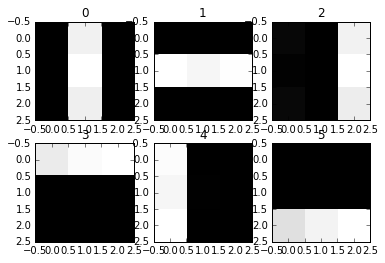

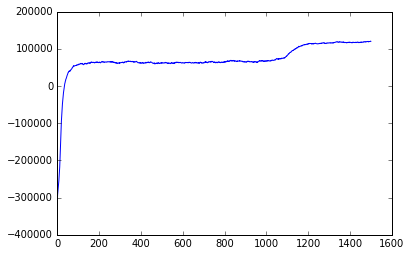

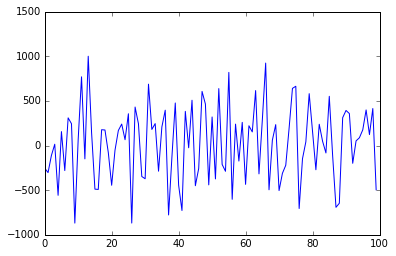

In [26]:
plot_images(plt, results, (rows, rows), (2, rows))
plt.figure()
plt.plot(blslda.loglikelihoods)
plt.figure()
plt.plot(np.diff(blslda.loglikelihoods)[-100:])